In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
from rembg import remove 
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# def display(gambar, titel,rows,columns):
#     fig = plt.figure(figsize=(3*columns, rows*2)) 
#     for i in range(rows*columns):
#         fig.add_subplot(rows,columns, i+1) 
#         plt.imshow(gambar[i], cmap='gray')
#         plt.axis('off') 
#         plt.title(titel[i])

def display_multiple_labels(data, filenames, labels, rows_per_label, columns):
    fig, axs = plt.subplots(rows_per_label, columns, figsize=(3 * columns, rows_per_label * 2))
    
    for i, label in enumerate(labels):
        label_data = [data[j] for j, (filename, lbl) in enumerate(filenames) if lbl == label]
        label_filenames = [filename for filename, lbl in filenames if lbl == label]
        
        for j in range(rows_per_label):
            axs[j, i].imshow(label_data[j], cmap='gray')
            axs[j, i].axis('off')
            axs[j, i].set_title(label_filenames[j])
            
    plt.tight_layout()
    plt.show()


In [3]:
def insertGambar(folder, banyakGambar):
    data = []
    filenames = []
    datalabel = [] 
    # path = []
    for label in os.listdir(folder):
        if os.path.isdir(os.path.join(folder, label)):  
            datalabel.append(label)
            print(f"Processing label: {label}")
            i = 0
            for filename in tqdm(os.listdir(os.path.join(folder, label))):
                img = cv.imread(os.path.join(folder, label, filename))
                if img is not None:
                    filenames.append((filename, label))
                    # path.append(label)
                    data.append(img)
                    
                    i += 1
                if i == banyakGambar:
                    break
    return data, filenames, datalabel

In [4]:
data, filenames,labels = insertGambar("data/",100) 

Processing label: Blight


  0%|          | 0/1146 [00:00<?, ?it/s]

  9%|▊         | 99/1146 [00:00<00:05, 208.42it/s]


Processing label: Common_Rust


  8%|▊         | 99/1306 [00:00<00:02, 494.02it/s]


Processing label: Gray_Leaf_Spot


 17%|█▋        | 99/574 [00:00<00:01, 254.92it/s]


Processing label: Healthy


  9%|▊         | 99/1162 [00:00<00:01, 546.90it/s]


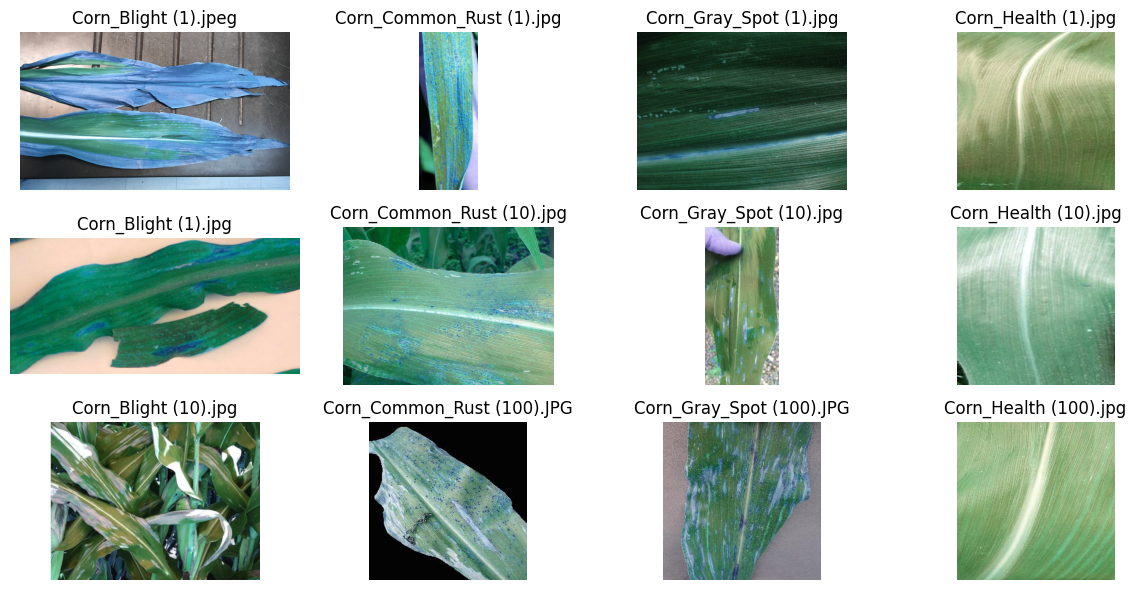

In [5]:
display_multiple_labels(data, filenames, labels, 3, 4)

In [6]:
def resizeImage(data, ukuran):
    resizeData = []
    for img in data:
        resized_img = cv.resize(img, (ukuran, ukuran))
        resizeData.append(resized_img)    
    return resizeData

In [7]:
data = resizeImage(data, 150)

In [8]:
def hapusBackgroundData(data):
    hasil = []
    i=0
    for img in tqdm(data):
        i+=1
        if i>=300:
            hasil.append(img)
            continue
        rmBg = remove(img) 
        hasil.append(rmBg)
    return hasil

In [9]:
preprocessing1 = hapusBackgroundData(data)

100%|██████████| 400/400 [11:02<00:00,  1.66s/it]


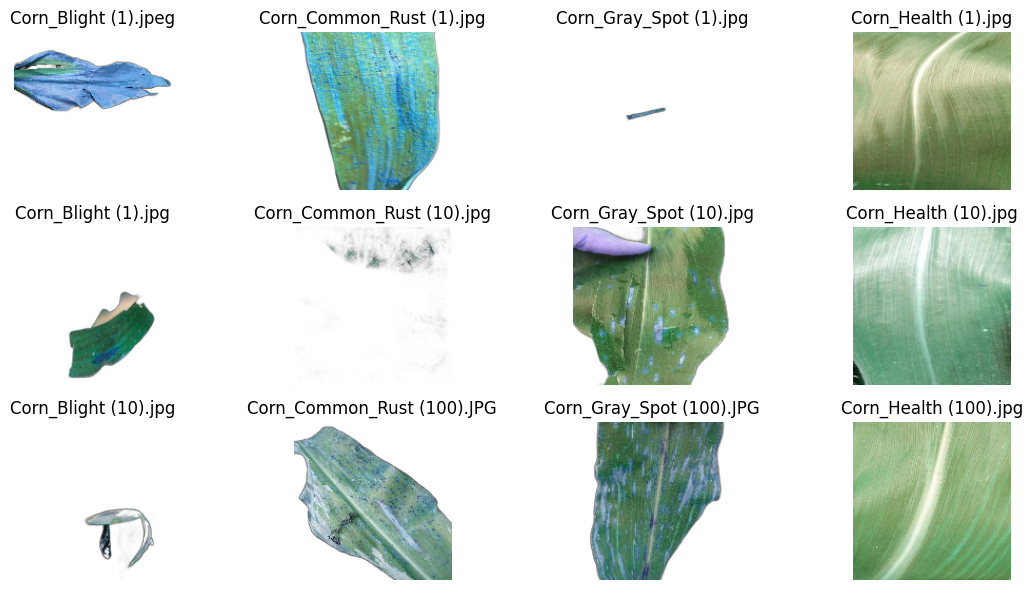

In [10]:
display_multiple_labels(preprocessing1, filenames, labels, 3, 4)

In [11]:
def grayscale(data):
    grayData = []
    for img in data:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        grayData.append(gray)
    return grayData

In [12]:
preprocessing2 = grayscale(preprocessing1)

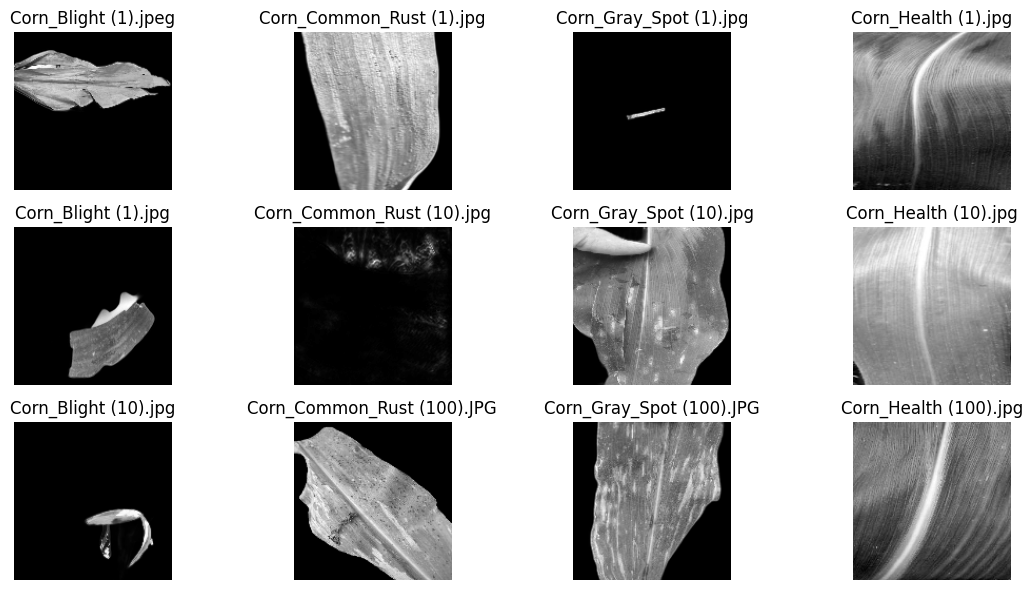

In [13]:
display_multiple_labels(preprocessing2, filenames, labels, 3, 4)

In [14]:
def ekualisasi(img):
    histogram = np.zeros(256).astype(int)
    hImg, wImg = img.shape

    for i in range(hImg):
        for j in range(wImg):
            value = img[i, j]
            histogram[value] += 1
    
    dist_kumulatif = np.zeros(256).astype(int)
    dist_kumulatif[0] = histogram[0]
    for i in range(1, 256):
        dist_kumulatif[i] = dist_kumulatif[i-1] + histogram[i]
    
    target_value = dist_kumulatif * (256-1) / (hImg * wImg)
    target_value = np.floor(target_value).astype(int)

    result = target_value[img]
    return result

In [15]:
def ekualisasiData(data):
    hasil = []
    for img in data:
        gambar = ekualisasi(img)
        hasil.append(gambar)
    return hasil

In [16]:
preprocessing3 = ekualisasiData(preprocessing2)

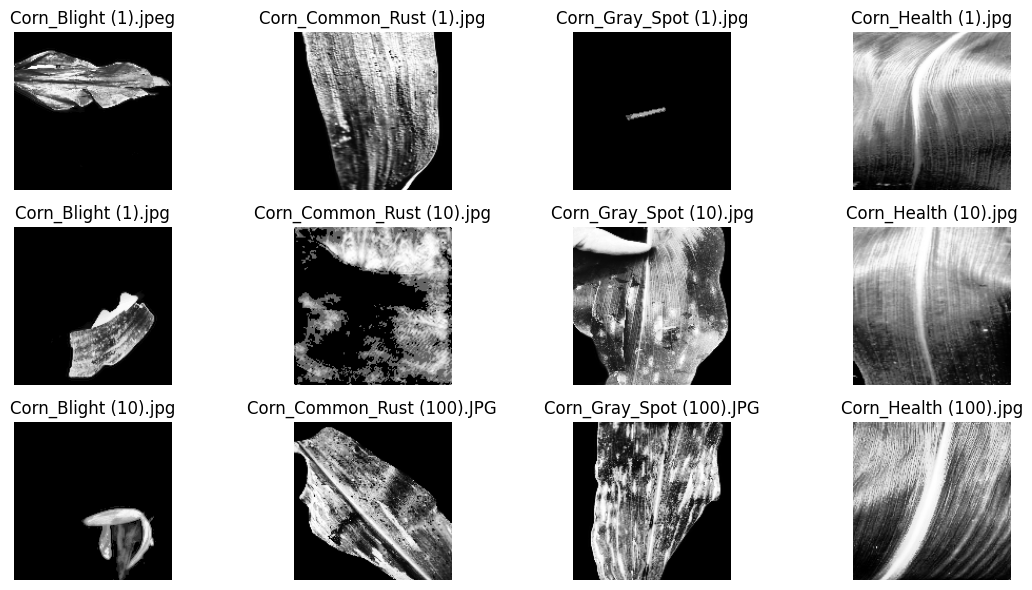

In [17]:
display_multiple_labels(preprocessing3, filenames, labels, 3, 4)

In [18]:
def meanFilter(image):
    heightImage, widthImage = image.shape
    padImage = np.pad(image, (1,1), mode='edge')
    kernel = np.zeros((3,3))
    result = np.zeros([heightImage, widthImage]).astype(int)
    for i in range(heightImage):
        for j in range(widthImage):
            temp = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    temp += padImage[i+k, j+l]
            result[i, j] = int(temp/(kernel.shape[0]*kernel.shape[1]))
    return result

In [19]:
def meanFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = meanFilter(img)
        hasil.append(gambar)
    return hasil

In [20]:
preprocessing4 = meanFilterData(preprocessing3)

100%|██████████| 400/400 [00:25<00:00, 15.85it/s]


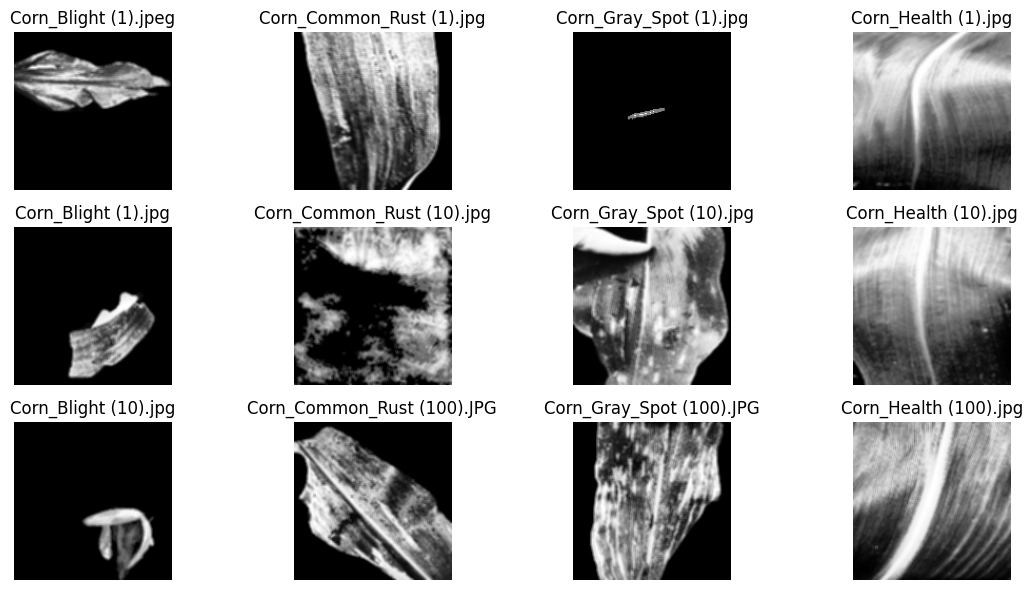

In [21]:
display_multiple_labels(preprocessing4, filenames, labels, 3, 4)

In [22]:
def dilate(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    pad_height, pad_width = k_height // 2, k_width // 2
    
    padded_image = np.pad(image, ((pad_height, pad_width), (pad_height, pad_width)), mode='constant', constant_values=0)
    dilated_image = np.zeros_like(image)
    
    for i in range(height):
        for j in range(width):
            dilated_image[i, j] = np.max(padded_image[i:i+k_height, j:j+k_width] * kernel)
    
    return dilated_image

def erode(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    pad_height, pad_width = k_height // 2, k_width // 2
    
    padded_image = np.pad(image, ((pad_height, pad_width), (pad_height, pad_width)), mode='constant', constant_values=255)
    eroded_image = np.zeros_like(image)
    
    for i in range(height):
        for j in range(width):
            eroded_image[i, j] = np.min(padded_image[i:i+k_height, j:j+k_width] * kernel)
    
    return eroded_image

def closing(image, kernel):
    dilated_image = dilate(image, kernel)
    closed_image = erode(dilated_image, kernel)
    return closed_image

def closingData(data):
    hasil = []
    kernel = np.ones((3, 3), dtype=np.uint8)  
    for img in tqdm(data):
        gambar = closing(img, kernel)
        hasil.append(gambar)
    return hasil

In [23]:
preprocessing5 = closingData(preprocessing4)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


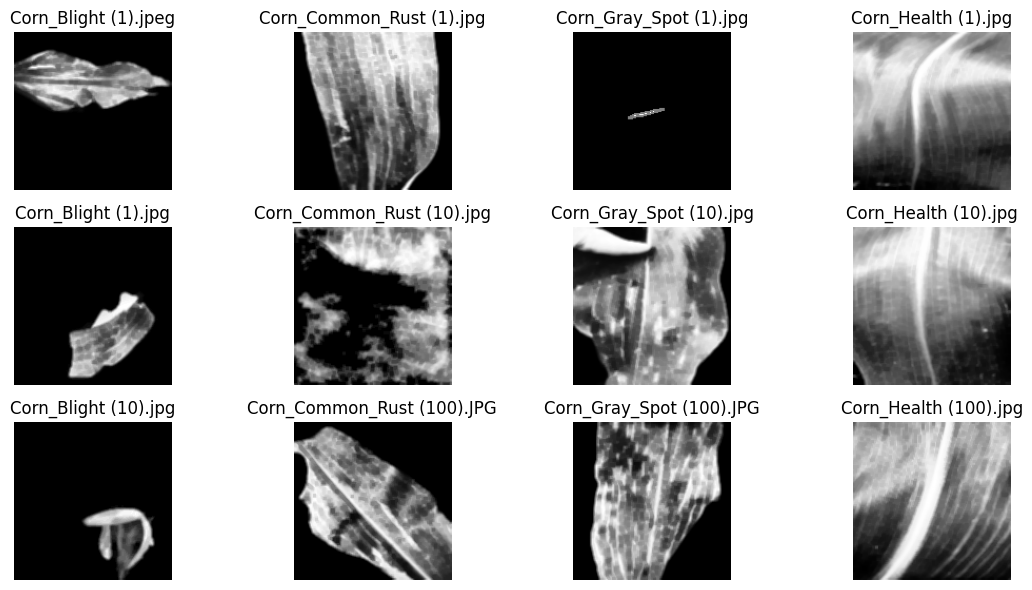

In [24]:
display_multiple_labels(preprocessing5, filenames, labels, 3, 4)

### Data Augmentation

In [25]:
def rotasi (image, derajat):
    rotasi = image.copy()
    sudut= np.deg2rad(derajat)
    cos=np.cos(sudut)
    sin=np.sin(sudut)
    heighttengah = int((image.shape[1]-1)/2)
    widthtengah = int((image.shape[0]-1)/2)
    for i in range (rotasi.shape[0]):
        for j in range (rotasi.shape[1]):
            x=(i-heighttengah)*cos+(j-widthtengah)*sin
            y=-(i-heighttengah)*sin+(j-widthtengah)*cos
            x = int(x + heighttengah)
            y = int(y + widthtengah)
            if x>=0 and y>=0 and x<rotasi.shape[0] and y<rotasi.shape[1] :
                rotasi[i][j]= image[x][y]
    return rotasi

In [26]:
def augmentasi(data, filenames, path, banyakData):
    augmented_data = []
    augmented_filenames = []
    augmented_path = []
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_path.append(path[i])
        augmented_filenames.append(filenames[i])
        for j in range(banyakData):
            if j % 3 == 0:
                augmented_data.append(rotasi(data[i], 90))
                augmented_filenames.append(filenames[i])
                augmented_path.append(path[i])
            elif j % 3 == 1:
                augmented_data.append(rotasi(data[i], 180))
                augmented_filenames.append(filenames[i])
                augmented_path.append(path[i])
            elif j % 3 == 2:
                augmented_data.append(rotasi(data[i], 240))
                augmented_filenames.append(filenames[i])
                augmented_path.append(path[i])
    return augmented_data, augmented_filenames, augmented_path

In [27]:
# augmented_data, augmented_filenames, path = augmentasi(preprocessing3, filenames, path, 3)

In [28]:
def matriksTransformasi(matriks):
    hasil = np.zeros(matriks.shape)
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            hasil[i][j] = matriks[j][i]
    return hasil
def sum(matriks):
    hasil = 0
    for i in range(len(matriks)):
        for j in range(len(matriks[0])):
            hasil += matriks[i][j]
    return hasil

In [29]:
def derajat(img, derajat):
    max = int(np.max(img))
    temp=np.zeros([max+1,max+1])
    if derajat == 0:
        for i in range (len(img)):
            for j in range (len(img[0])-1):
                temp[img[i,j],img[i,j+1]] += 1
    elif derajat == 45:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i+1,j],img[i,j+1]] += 1
    elif derajat == 90:
        for i in range (len (img)-1):
            for j in range (len (img[0])):
                temp[img[i+1,j],img[i,j]] += 1
    elif derajat == 135:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i,j],img[i+1,j+1]] += 1
    hasil = temp+matriksTransformasi(temp)
    total = sum(hasil)
    for i in range (len (hasil)):
        for j in range (len (hasil)):
            hasil[i,j]/=total
    return hasil

In [30]:
def GLCM(image):
    hasil = []
    for img in tqdm(image):
        data = []
        data.append(derajat(img,0))
        data.append(derajat(img,45))
        data.append(derajat(img,90))
        data.append(derajat(img,135))
        hasil.append(data)    
    return hasil 

In [31]:
hasilGLCM = GLCM(preprocessing5)

100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


In [32]:
def contrast (data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*pow(i-j,2)
    return hasil
def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*abs(i-j)
    return hasil
def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=(data[i,j]/(1+pow(i-j,2)))
    return hasil
def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil
def correlation(data):
    mean = np.zeros((2))
    std = np.zeros((2))
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean[0] += i*data[i,j]
            mean[1] += j*data[i,j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std[0] += pow(i-mean[0],2)*data[i,j]
            std[1] += pow(j-mean[1],2)*data[i,j]
    std[0] = math.sqrt(std[0])
    std[1] = math.sqrt(std[1])
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i-mean[0])*(j-mean[1])*data[i,j]/(std[0]*std[1])
    return hasil
def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy
def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [33]:
def ekstraksi(data):
    result = []
    for i in tqdm(range(len(data))):
        extracted_data = []
        # extracted_data.append(data[i])
        for j in range(len(data[i])):
            contrast_val = contrast(data[i][j])
            extracted_data.append(contrast_val)
        for j in range(len(data[i])):
            dissimilarity_val = dissimilarity(data[i][j])
            extracted_data.append(dissimilarity_val)
        for j in range(len(data[i])):
            homogeneity_val = homogeneity(data[i][j])
            extracted_data.append(homogeneity_val)
        for j in range(len(data[i])):
            energy_val = energy(data[i][j])
            extracted_data.append(energy_val)
        for j in range(len(data[i])):
            correlation_val = correlation(data[i][j])
            extracted_data.append(correlation_val)
        for j in range(len(data[i])):
                asm_val = asm(data[i][j])
                extracted_data.append(asm_val)
                entropy_val = entropy(data[i][j])
                extracted_data.append(entropy_val)
        result.append(extracted_data)
    return result




In [34]:
hasilEkstraksi = ekstraksi(hasilGLCM) 

100%|██████████| 400/400 [33:35<00:00,  5.04s/it]   


In [35]:
hasilEkstraksiSimpan = hasilEkstraksi

In [36]:
for i in range(len(hasilEkstraksi)):
    hasilEkstraksi[i].append(labels[i % len(labels)])

In [37]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
headers = []
for fitur in fiturs:
    headers.extend([f'{fitur}_0', f'{fitur}_45', f'{fitur}_90', f'{fitur}_135'])
for angle in angles:
    headers.extend([f'asm_{angle}', f'entropy_{angle}'])
headers.append('Label')
df = pd.DataFrame(hasilEkstraksi, columns=headers)
df.to_csv('sesudahPreprocessing-ke6.csv', index=False)

In [38]:
df.head(102)

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,Label
0,2.952573,17.635422,14.605817,16.189541,0.569664,1.576956,1.393199,1.452187,0.858896,0.785759,...,0.974227,0.520322,2.363119,0.510458,2.647181,0.512917,2.572418,0.511811,2.622691,Blight
1,2.790962,3.405883,3.027562,7.628846,0.442237,0.511869,0.484743,0.804468,0.902863,0.886374,...,0.964437,0.651535,1.645389,0.648970,1.686946,0.651375,1.663427,0.644812,1.774755,Common_Rust
2,0.893244,1.503671,0.797808,1.780325,0.226130,0.301833,0.200224,0.350930,0.935334,0.923639,...,0.965278,0.754435,1.084222,0.750837,1.134509,0.755315,1.066816,0.749265,1.152086,Gray_Leaf_Spot
3,108.917897,110.946354,33.043803,164.697491,5.936152,6.599883,3.432617,7.919148,0.455688,0.345227,...,0.976631,0.039636,7.038925,0.038284,7.275704,0.041956,6.739885,0.037975,7.388080,Healthy
4,117.864027,147.044998,36.709217,146.165668,5.863043,7.169857,3.407472,7.274267,0.450125,0.322063,...,0.983342,0.015288,7.628056,0.014841,7.969970,0.017317,7.290575,0.014790,7.998184,Blight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,3.645101,3.125175,0.379195,4.759200,0.584340,0.573488,0.190380,0.681186,0.875893,0.866928,...,0.976929,0.617370,1.803950,0.617557,1.818640,0.628152,1.605097,0.613672,1.854807,Common_Rust
98,68.504430,39.518085,23.038300,136.196568,3.771454,3.629521,2.381655,5.356966,0.486972,0.402458,...,0.984696,0.030439,7.112861,0.030674,7.240682,0.031575,6.855700,0.029792,7.419674,Gray_Leaf_Spot
99,12.465145,18.297509,2.404966,10.205711,1.203132,1.465745,0.470112,1.110445,0.831469,0.811277,...,0.978805,0.551475,2.319798,0.549864,2.391459,0.561804,2.099378,0.553688,2.326914,Healthy
100,140.420761,185.555020,42.844966,162.463538,6.213065,7.736363,3.279329,6.986397,0.497553,0.395914,...,0.977316,0.058090,6.819362,0.057486,7.138917,0.062990,6.425168,0.057778,7.062861,Blight


In [39]:
df = pd.read_csv('sesudahPreprocessing-ke6.csv')
x = df.drop('Label', axis=1)
y = df['Label']

In [40]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=42)

In [41]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

In [44]:
knn = KNeighborsClassifier()
svm = SVC()
rf = RandomForestClassifier()

knn.fit(xTrain, yTrain)
svm.fit(xTrain, yTrain)
rf.fit(xTrain, yTrain)

yPredKnn = knn.predict(xTest)
yPredSvm = svm.predict(xTest)
yPredRf = rf.predict(xTest)

acc_knn = accuracy_score(yTest, yPredKnn)
precision_knn = precision_score(yTest, yPredKnn, average='weighted')
recall_knn = recall_score(yTest, yPredKnn, average='weighted')
f1_knn = f1_score(yTest, yPredKnn, average='weighted')

acc_svm = accuracy_score(yTest, yPredSvm)
precision_svm = precision_score(yTest, yPredSvm, average='weighted')
recall_svm = recall_score(yTest, yPredSvm, average='weighted')
f1_svm = f1_score(yTest, yPredSvm, average='weighted')

acc_rf = accuracy_score(yTest, yPredRf)
precision_rf = precision_score(yTest, yPredRf, average='weighted')
recall_rf = recall_score(yTest, yPredRf, average='weighted')
f1_rf = f1_score(yTest, yPredRf, average='weighted')

hasil = pd.DataFrame()
hasil['Model'] = ['KNN', 'SVM', 'Random Forest']
hasil['Accuracy'] = [acc_knn, acc_svm, acc_rf]
hasil['Precision'] = [precision_knn, precision_svm, precision_rf]
hasil['Recall'] = [recall_knn, recall_svm, recall_rf]
hasil['F1-Score'] = [f1_knn, f1_svm, f1_rf]
print(hasil)

           Model  Accuracy  Precision    Recall  F1-Score
0            KNN  0.258333   0.257857  0.258333  0.253440
1            SVM  0.241667   0.298611  0.241667  0.170125
2  Random Forest  0.200000   0.204226  0.200000  0.199774


c:\Users\daraf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
